# EGM Signal Prediction: Autoregressive Models

This repository contains code and resources for predicting EGM (Electrogram) signals using autoregressive models. The goal is to take $2.5$ seconds of EGM data at a sampling rate of $500$ Hz, and use the first $2$ seconds to predict the next $0.5$ seconds.

In [ ]:

import os
import re
import pickle
import lzma

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import pacf, adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.recursive_ls import RecursiveLS

## 1. Stochastic Modeling of Bio-Signals

Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space. We define the discrete-time intracardiac electrogram (EGM) signal as a real-valued stochastic process $(X_t)_{t \in \mathbb{Z}}$, where each $X_t \in \mathcal{L}^2(\Omega, \mathcal{F}, \mathbb{P})$ (i.e., $E[X_t^2] < \infty$ for all $t$). For the purpose of linear prediction, we generally assume the process is weakly stationary (or second-order stationary). This implies that the first two moments are time-invariant:

1. $\mathbb{E}[X_t] = \mu < \infty$ for all $t \in \mathbb{Z}$ (constant mean)
2. $\mathbb{C}\text{ov}(X_t, X_{t+h}) = \gamma(h)$ for all $t, h \in \mathbb{Z}$ (autocovariance depends only on lag $h$)

The theoretical justification for modeling EGMs using autoregressive structures stems from Wold's Decomposition Theorem. Any zero-mean, purely non-deterministic stationary time series $X_t$​ can be expressed as an infinite moving average representation:

$$
X_t = \sum_{j=0}^{\infty} \psi_j \varepsilon_{t-j},
$$

where $\psi_0 = 1$ and $\sum_{j=0}^{\infty} \psi_j^2 < \infty$, and $\{\varepsilon_t\}_{t \in \mathbb{Z}}$ is a white noise process with zero mean and variance $\sigma^2$. This representation indicates that the current value of the process can be expressed as a linear combination of past white noise innovations.

Note that in practical applications, the assumption of stationarity may not hold perfectly for EGM signals due to physiological variations. However, over short time intervals (e.g., 2.5 seconds), the stationarity assumption is often a reasonable approximation that allows for effective modeling and prediction using autoregressive techniques.

### 1.1. The Autoregressive Process $\text{AR}(p)$

While Wold's theorem suggests an infinite moving average, estimating infinite parameters is computationally infeasible. We approximate this using an Autoregressive process of order $p$, denoted as $\text{AR}(p)$. An $\text{AR}(p)$ process describes $X_t$ as a linear combination of its own past $p$ values plus a stochastic error term:

$$
X_t = c + \sum_{i=1}^{p} \phi_i X_{t-i} + \varepsilon_t,
$$

where $c$ is a constant, $\phi_1, \phi_2, \ldots, \phi_p$ are the autoregressive coefficients, and $\varepsilon_t$ is white noise with zero mean and variance $\sigma^2$. Using the backshift lag operator $L$ where $L^k X_t ​= X_{t−k}$​, we can rewrite this as:

$$
\phi(L) X_t = c + \varepsilon_t,
$$

where $\phi(L) = 1 - \phi_1 L - \phi_2 L^2 - \ldots - \phi_p L^p$ is the characteristic polynomial of the process.

For the $\text{AR}(p)$ process to be stationary (and causal), the roots of the characteristic polynomial $\Phi(z) = 0$ must lie outside the unit circle in the complex plane ($\lvert z \rvert > 1$). This ensures that the influence of past shocks decays over time, returning the EGM to its mean level.

Training an AR model involves estimating the vector $\boldsymbol{\phi} = (\phi_1​, \phi_2, \ldots, \phi_p​)^\top$. Common methods include:

1. **Yule-Walker Equations**: By multiplying the AR definition by $X_{t−k}$​ and taking expectations, we derive a system of linear equations relating the parameters $\phi_i$ to the autocorrelation function $\rho(h) = \frac{\gamma(h)}{\gamma(0)}$​:

$$
\rho(h) = \sum_{i=1}^{p} \phi_i \rho(h-i), \quad h = 1, 2, \ldots, p.
$$

2. **Least Squares Estimation**: Minimizing the sum of squared residuals $\sum \varepsilon_t^2$​. For Gaussian errors, OLS is equivalent to Maximum Likelihood Estimation (MLE).

### 1.2. Generalizations: The Autoregressive Moving Average Process $\text{ARMA}(p, q)$ and the Autoregressive Integrated Moving Average Process $\text{ARIMA}(p, d, q)$

To capture shock dynamics more efficiently, we may extend the AR framework to include a moving average component of order $q$, resulting in the $\text{ARMA}(p, q)$ model:

$$
X_t = c + \sum_{i=1}^{p} \phi_i X_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t,
$$

where $\theta_1, \theta_2, \ldots, \theta_q$ are the moving average coefficients. While the AR part ($\phi_i$) models the system's "memory" or internal momentum (e.g., refractory periods in cardiac tissue), the MA part ($\theta_j$) models the persistence of external shocks.

For non-stationary EGM signals, we can apply differencing $d$ times to achieve stationarity, leading to the $\text{ARIMA}(p, d, q)$ model:

$$
(1 - L)^d X_t = c + \sum_{i=1}^{p} \phi_i (1 - L)^d X_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t,
$$

where $(1 - L)^d$ denotes the differencing operator ($(1 - L) X_t = X_t - X_{t-1}$​) applied $d$ times. This differencing essentially induces stationarity before fitting the ARMA model to the transformed data.

### 1.3. Non-Linear and Time-Varying Extensions: Time-Varying AR (TVAR)

The standard AR and ARMA processes assume structural stability: the coefficients $\phi_i$ and $\theta_j$ remain constant throughout the observation window. However, bio-signals often exhibit non-stationarity or regime-switching behavior. To address this, we consider dynamic extensions.

If the underlying generative mechanism evolves over time (e.g., changing heart rate or conduction velocity), we generalize the $\text{AR}(p)$ process to allow time-dependent coefficients:

$$
X_t = c(t) + \sum_{i=1}^{p} \phi_i(t) X_{t-i} + \varepsilon_t.
$$

Here the vector of coefficients $\boldsymbol{\phi}_t = (\phi_1(t), \phi_2(t), \ldots, \phi_p(t))^\top$​ is itself a stochastic process. The estimation of $\boldsymbol{\phi}_t$​ usually requires a State-Space representation, solved recursively via the Kalman Filter or Recursive Least Squares (RLS) with a forgetting factor $\lambda \in (0, 1]$.

In the state-space form, we have:

1. **The state (observation) equation**: $X_t = \mathbf{H}_t^\top \boldsymbol{\phi}_t + \varepsilon_t$, where $\mathbf{H}_t = (X_{t-1}, X_{t-2}, \ldots, X_{t-p})^\top$ is the regression vector.
2. **The state transition equation**: $\boldsymbol{\phi}_t = \boldsymbol{\phi}_{t-1} + \mathbf{w}_t$, where $\boldsymbol{\eta}_t$ is process noise, often modeled as Gaussian.

## 1.4. Relevance to EGM Prediction

Physiologically, cardiac electrophysiology is governed by reaction-diffusion systems (e.g., the monodomain or bidomain equations). Discretizing these continuous dynamical systems naturally leads to difference equations, which are structurally identical to autoregressive processes.

### 1.4.1. Physical Interpretation of Coefficients

In an AR model, the coefficients $\phi_i$​ implicitly capture the local conduction properties and refractoriness of the tissue. A stable $\boldsymbol{\phi}$ vector implies stable tissue conductivity.

### 1.4.2. Handling Rate Adaptation

Cardiac tissue exhibits "restitution," where the action potential duration depends on the previous diastolic interval. A TVAR model is theoretically superior here, as it can adapt its coefficients $\boldsymbol{\phi}_t$​ to reflect the changing conduction velocity during acceleration or deceleration of the heart rate.

### 1.4.3. Efficiency vs. Accuracy

Standard AR Fits instance-specific parameters via OLS (instantaneous). It assumes the rhythm is stable within the 2.5s window. On the other hand, TVAR/SETAR offers higher fidelity for irregular rhythms (fibrillation) but requires iterative estimation (Kalman Filtering), increasing computational cost.

## 2. Data Loading and Preprocessing

In this section, we load the intracardiac electrogram (EGM) dataset. Let $N$ be the total number of observed processes (electrodes, differing by patient, and let $T$ be the total time duration of the recording (1250 samples for 2.5 seconds at $500$ Hz). The dataset is represented as a matrix $\mathbf{X} \in \mathbb{R}^{N \times T}$.

We partition the time dimension into an Observation Window (History) and a Prediction Horizon (Future). Additionally, we enforce the Weak Stationarity condition by centering the data (subtracting the mean) to ensure $\mathbb{E}[X_t​] \approx 0$​.

In [2]:
SAMPLING_FREQ = 500       # (Hz)
DT = 1000 / SAMPLING_FREQ # (ms) Sampling interval 
T_OBS = 1000              # (samples) Observation window
T_PRED = 250              # (samples) Prediction horizon
T = T_OBS + T_PRED        # (samples) Total time window

EXCEL_PATH = "./MapsInfo.xlsx"
EGMS_DIR = "./EGMS"


In [3]:
maps_df = pd.read_excel(EXCEL_PATH)
patient_to_map = dict(zip(maps_df["Patient"], maps_df["AF"]))

raw_data = [] 

print(f"Initializing Data Loader (Fs = {SAMPLING_FREQ}Hz)...")

for filename in os.listdir(EGMS_DIR):
    if filename.endswith("_EGMs.xz"):
        # Regex to extract Patient ID consistent with MapsInfo
        match = re.search(r"Patient (\d{4}_\d{2}_\d{2})_EGMs\.xz", filename)
        if match:
            patient_date = match.group(1)
            map_name = patient_to_map.get(patient_date)
            
            if map_name is None:
                continue
                
            load_file_path = os.path.join(EGMS_DIR, filename)
            try:
                with lzma.open(load_file_path, "rb") as f:
                    file_content = pickle.load(f)
                
                # Validate Map Existence
                if map_name in file_content["map"].tolist():
                    map_index = file_content["map"].tolist().index(map_name)
                    
                    # Extract Realization Matrix
                    # Original: (Time, Space) -> Transpose to (Space, Time)
                    # Shape: (N_spatial, T_temporal)
                    raw_signal = file_content["bipolar"][map_index].T 
                    
                    # Ensure signal is sufficiently long
                    if raw_signal.shape[1] >= T:
                        # Truncate to exact analysis window
                        raw_data.append(raw_signal[:, :T])
                        print(f"Loaded {filename}: {raw_signal.shape[0]} realizations.")
                        
            except Exception as e:
                print(f"Error loading {filename}: {e}")

Initializing Data Loader (Fs = 500Hz)...
Loaded Patient 2021_10_19_EGMs.xz: 3736 realizations.
Loaded Patient 2021_10_18_EGMs.xz: 3936 realizations.
Loaded Patient 2021_11_17_EGMs.xz: 5865 realizations.
Loaded Patient 2021_11_15_EGMs.xz: 9303 realizations.
Loaded Patient 2021_10_05_EGMs.xz: 3944 realizations.
Loaded Patient 2021_11_10_EGMs.xz: 6422 realizations.
Loaded Patient 2021_11_02_EGMs.xz: 8720 realizations.
Loaded Patient 2021_11_16_EGMs.xz: 4848 realizations.
Loaded Patient 2021_11_12_EGMs.xz: 13984 realizations.
Loaded Patient 2021_10_04_EGMs.xz: 2008 realizations.
Loaded Patient 2021_11_08_EGMs.xz: 6129 realizations.
Loaded Patient 2021_09_30_EGMs.xz: 10875 realizations.


In [4]:

if raw_data:
    # Stack all realizations into a single matrix X
    # X_matrix shape: (Total_Samples, Total_Time)
    X_matrix = np.concatenate(raw_data, axis=0)
    
    # 1. Enforce Zero-Mean (Center the data)
    # Essential for AR(p) models which assume E[X_t] = 0 (or constant c)
    # We subtract the mean of the HISTORY to avoid data leakage from the future
    history_mean = np.mean(X_matrix[:, :T_OBS], axis=1, keepdims=True)
    X_centered = X_matrix - history_mean
    
    # 2. Train/Test Split (Instance-based)
    # We reserve a subset of distinct signals for testing.
    # Note: For AR models, "Training" is instance-specific (fitting coefficients to history).
    # This split is purely for evaluation purposes.
    X_train, X_test = train_test_split(X_centered, test_size=0.2, random_state=42)
    
    print('\n' + '='*40)
    print(f"Data Loaded Successfully.")
    print(f"Total Process Realizations (N): {X_matrix.shape[0]}")
    print(f"Time Steps (T): {X_matrix.shape[1]} ({T * DT/1000} seconds)")
    print(f"Evaluation Set Size: {X_test.shape[0]} signals")
    print(f"Zero-Mean Assumption Applied: Yes")
    print('='*40)
    
else:
    raise ValueError("No valid data found. Please check directory paths.")

X_test_history = X_test[:, :T_OBS]
X_test_target  = X_test[:, T_OBS:]


Data Loaded Successfully.
Total Process Realizations (N): 79770
Time Steps (T): 1250 (2.5 seconds)
Evaluation Set Size: 15954 signals
Zero-Mean Assumption Applied: Yes


## 3. $\text{AR}(p)$ Model

In this section, we implement the $\text{AR}(p)$ model:

$$
X_t = c + \sum_{i=1}^{p} \phi_i X_{t-i} + \varepsilon_t.
$$

Unlike global Machine Learning models (e.g., RNNs) which learn a universal function $f(\cdot)$ across all patients, the AR approach treats each 2-second window as a distinct realization. We estimate a unique set of parameters $\boldsymbol{\phi}$ for each instance at inference time.

### 3.1. Order Selection (Determining $p$)

The critical hyperparameter is the order $p$. If it is too low, the model underfits; if too high, it overfits. To determine the optimal $p$, we employ two methods:

1. **Partial Autocorrelation Function (PACF)**: Measures the correlation between $X_t$​ and $X_{t−k}$​ after removing the effects of intermediate lags. The lag $k$ where the PACF cuts off to zero suggests the appropriate order.
2. **Akaike Information Criterion (AIC)**: A metric that rewards goodness-of-fit but penalizes model complexity (number of parameters). We seek to minimize $\text{AIC} = 2k − 2 \log(\hat{L})$.

We analyze a random subset of signals to determine a statistically sound $p$ for the dataset.

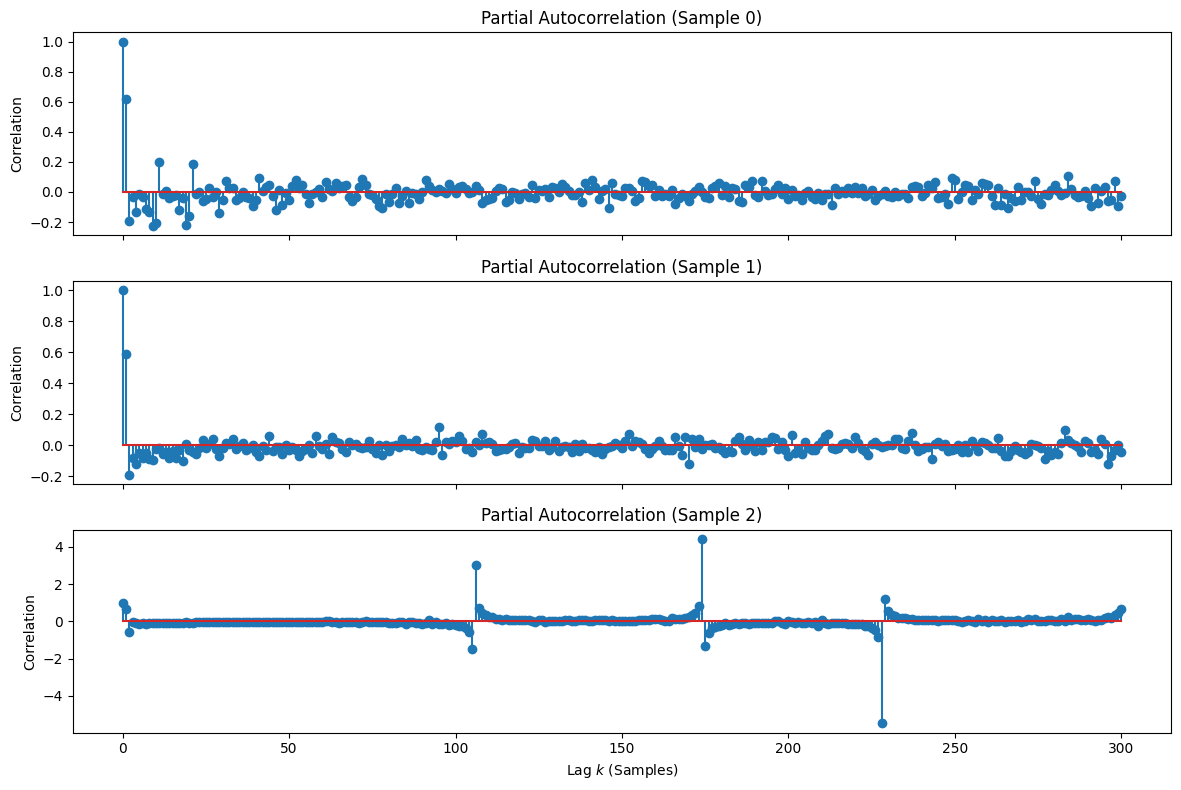

Searching for optimal lag order p using AIC...

Average AIC scores per lag (Lower is better):
Lag 1: -4801.86
Lag 2: -4936.80
Lag 3: -4945.80
Lag 4: -4961.73
Lag 5: -4963.95
Lag 6: -4968.07
Lag 7: -4968.96
Lag 8: -4971.00
Lag 9: -4971.13
Lag 10: -4975.55
Lag 11: -4975.86
Lag 12: -4973.41
Lag 13: -4981.38
Lag 14: -4978.95
Lag 15: -4975.98
Lag 16: -4974.99
Lag 17: -4970.54
Lag 18: -4968.45
Lag 19: -4965.63
Lag 20: -4964.26
Lag 21: -4960.07
Lag 22: -4955.75
Lag 23: -4951.87
Lag 24: -4946.74
Lag 25: -4941.21
Lag 26: -4936.89
Lag 27: -4931.46
Lag 28: -4927.03
Lag 29: -4922.48
Lag 30: -4918.11
Lag 31: -4912.66
Lag 32: -4906.07
Lag 33: -4899.78
Lag 34: -4893.83
Lag 35: -4887.21
Lag 36: -4880.91
Lag 37: -4874.83
Lag 38: -4868.70
Lag 39: -4862.47
Lag 40: -4858.62
Lag 41: -4852.17
Lag 42: -4845.31
Lag 43: -4838.38
Lag 44: -4831.59
Lag 45: -4824.81
Lag 46: -4818.35
Lag 47: -4811.15
Lag 48: -4804.30
Lag 49: -4797.59
Lag 50: -4791.66

Selected Order: p = 13 (covering 26.0 ms)


In [5]:
n_samples_analysis = 3
lags_to_plot = 300

fig, axes = plt.subplots(n_samples_analysis, 1, figsize=(12, 8), sharex=True)

for i in range(n_samples_analysis):
    # Calculate PACF
    # method='yw' (Yule-Walker) is standard for this
    pacf_vals = pacf(X_test_history[i], nlags=lags_to_plot, method='yw')
    
    # Plot
    axes[i].stem(range(len(pacf_vals)), pacf_vals)
    axes[i].set_title(f"Partial Autocorrelation (Sample {i})")
    axes[i].set_ylabel("Correlation")

axes[-1].set_xlabel("Lag $k$ (Samples)")
plt.tight_layout()
plt.show()

print("Searching for optimal lag order p using AIC...")
test_lags = list(range(1, 51))  # Test lags from 1 to 50
aic_scores = {p: [] for p in test_lags}
subset_idx = np.random.choice(len(X_test_history), 50, replace=False) # Test on 50 samples

for idx in subset_idx:
    signal = X_test_history[idx]
    for p in test_lags:
        try:
            model = AutoReg(signal, lags=p, trend='n').fit()
            aic_scores[p].append(model.aic)
        except:
            pass

# Compute average AIC per lag
avg_aic = {p: np.mean(scores) for p, scores in aic_scores.items()}
best_p = min(avg_aic, key=avg_aic.get)

print("\nAverage AIC scores per lag (Lower is better):")
for p, score in avg_aic.items():
    print(f"Lag {p}: {score:.2f}")

print(f"\nSelected Order: p = {best_p} (covering {best_p * DT} ms)")
AR_LAG = best_p

### 3.2. Instance-Specific Prediction

We now proceed to evaluate the model on the test set. For every signal in the test set:

1. We fit an $\text{AR}(p)$ model to the History ($1000$ points) via Ordinary Least Squares.
2. We forecast the Future ($250$ points).
3. We compare the forecast against the Target.

In [8]:
N_EVAL_SAMPLES = 50 # Number of samples to evaluate (set to len(X_test) for full run)
indices_to_evaluate = np.arange(N_EVAL_SAMPLES)
# indices_to_evaluate = np.random.choice(len(X_test_history), N_EVAL_SAMPLES, replace=False)

# Storage
ar_predictions = []
ar_targets = []
ar_mses = []

print(f"Running AR({AR_LAG}) on {N_EVAL_SAMPLES} samples...")

for idx in tqdm.tqdm(indices_to_evaluate):
    history = X_test_history[idx]
    target = X_test_target[idx]
    
    try:
        # 1. Fit Model
        # trend='n' because we already centered the data in Section 2
        model = AutoReg(history, lags=AR_LAG, trend='n', old_names=False).fit()
        
        # 2. Forecast
        # Start predicting from the end of history
        start_idx = len(history)
        end_idx = len(history) + T_PRED - 1
        forecast = model.predict(start=start_idx, end=end_idx, dynamic=False)
        
        # 3. Store
        ar_predictions.append(forecast)
        ar_targets.append(target)
        mse = mean_squared_error(target, forecast)
        # Check for NaN or Inf values
        if not (np.isnan(mse) or np.isinf(mse)):
            ar_mses.append(mse)
        
    except Exception as e:
        print(f"Convergence error at index {idx}: {e}")

# Convert to numpy arrays for vector operations
ar_predictions = np.array(ar_predictions)
ar_targets = np.array(ar_targets)

print(f"\nCompleted. Average MSE: {np.mean(ar_mses):.6f}")

Running AR(13) on 50 samples...


100%|██████████| 50/50 [00:00<00:00, 109.75it/s]


Completed. Average MSE: 0.006250


### 3.3. Evaluation and the Spike Metric

Given the sparse nature of EGMs (mostly isoelectric baselines with sharp activations), global MSE can be misleading. A model predicting a flat line achieves a low MSE but fails clinically.

We introduce Spike Metrics, which evaluate error only when the ground truth signal exceeds the $95$-th percentile of amplitude (i.e., during the heartbeat).

(50,)


50it [00:00, 7174.41it/s]

--- AR(13) Results ---
Global MSE:    0.006250
Spike MSE:     0.101578
Spike MAE:     0.178729


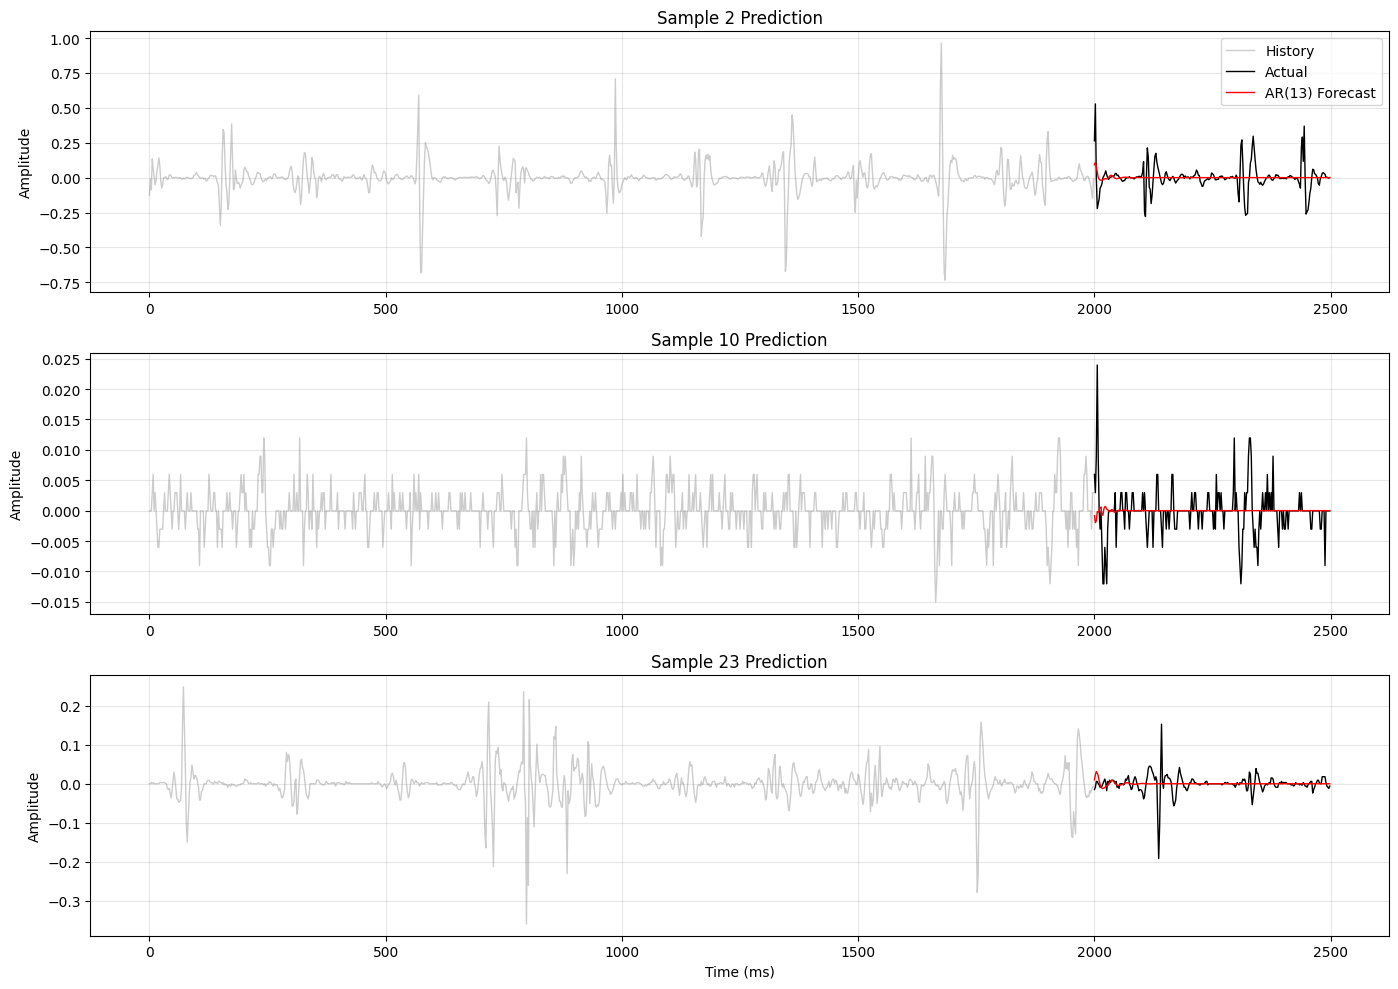

In [9]:
def calculate_metrics(predictions, targets, model_name="AR Model"):
    # 1. Global Metrics
    # Remove any samples with NaN, Inf, or very large values
    inf_or_nan_mask = np.any(np.isinf(predictions) | np.isnan(predictions) | (predictions > 1e6), axis=1)
    print(inf_or_nan_mask.shape)
    predictions = predictions[~inf_or_nan_mask]
    targets = targets[~inf_or_nan_mask]
    
    mse = np.mean((predictions - targets) ** 2)
    
    # 2. Spike Metrics (High Amplitude Regions)
    # Determine threshold per signal or globally? 
    # Here we do it globally for the batch to speed up, or per signal for precision.
    # We will do per-signal to be rigorous.
    
    spike_mses = []
    spike_maes = []
    
    for pred, true in tqdm.tqdm(zip(predictions, targets)):
        # Threshold: 95th percentile of the absolute signal amplitude
        threshold = np.percentile(np.abs(true), 95)
        mask = np.abs(true) > threshold
        
        if np.sum(mask) > 0:
            spike_mses.append(np.mean((pred[mask] - true[mask])**2))
            spike_maes.append(np.mean(np.abs(pred[mask] - true[mask])))
            
    avg_spike_mse = np.mean(spike_mses)
    avg_spike_mae = np.mean(spike_maes)
    
    print(f"--- {model_name} Results ---")
    print(f"Global MSE:    {mse:.6f}")
    print(f"Spike MSE:     {avg_spike_mse:.6f}")
    print(f"Spike MAE:     {avg_spike_mae:.6f}")
    
    return mse, avg_spike_mse

# Run Evaluation
ar_global_mse, ar_spike_mse = calculate_metrics(ar_predictions, ar_targets, f"AR({AR_LAG})")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
plot_indices = np.random.choice(len(ar_predictions), 3, replace=False)

time_hist = np.arange(0, T_OBS) * DT
time_pred = np.arange(T_OBS, T_OBS + T_PRED) * DT

for i, idx in enumerate(plot_indices):
    ax = axes[i]
    # We need to recover the history for this specific prediction
    # Note: 'indices_to_evaluate' maps local index 'idx' to global X_test index
    global_idx = indices_to_evaluate[idx]
    
    ax.plot(time_hist, X_test_history[global_idx], "gray", linewidth=1, alpha=0.4, label='History')
    ax.plot(time_pred, ar_targets[idx], "k-", linewidth=1, label='Actual')
    ax.plot(time_pred, ar_predictions[idx], "r-", linewidth=1, label=f'AR({AR_LAG}) Forecast')
    
    ax.set_title(f"Sample {global_idx} Prediction")
    ax.set_ylabel("Amplitude")
    if i == 0: ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

## 4. $\text{ARMA}(p, q)$ and $\text{ARIMA}(p, d, q)$ Models

In this section, we extend the autoregressive framework by introducing:

1. **Moving Average (MA) terms ($q$)**: Modeling the signal as a function of past errors (shocks).
2. **Integration (d)**: Differencing the data to remove trends (non-stationarity).

The general $\text{ARIMA}(p, d, q)$ equation is:

$$
\left(1 - \sum_{i=1}^{p} \phi_i L^i\right) (1 - L)^d X_t = c + \left(1 + \sum_{j=1}^{q} \theta_j L^j\right) \varepsilon_t.
$$

Note that this form is equivalent to the one presented earlier, just rearranged.

### 4.1. Stationarity Check (Determining $d$)

Before applying ARIMA, we must check if differencing ($d > 0$) is necessary. We use the Augmented Dickey-Fuller (ADF) test. The test's null hypothesis states that the time series has a unit root (non-stationary). If $p-\text{value} < 0.05$, we reject $H_0$​, conclude stationarity, and set $d = 0$.

In [10]:
print("Checking Stationarity on random samples...")
n_checks = 5
stationary_count = 0

sample_indices = np.random.choice(len(X_test_history), n_checks, replace=False)

for i, idx in enumerate(sample_indices):
    result = adfuller(X_test_history[idx])
    p_value = result[1]
    is_stationary = p_value < 0.05
    stationary_count += int(is_stationary)
    
    print(f"Sample {idx}: p-value = {p_value:.6f} -> {'Stationary' if is_stationary else 'Non-Stationary'}")

print(f"\nResult: {stationary_count}/{n_checks} samples are stationary.")
if stationary_count > n_checks / 2:
    print("Conclusion: EGMs are predominantly Stationary. We will set d = 0 (ARMA).")
    ARIMA_d = 0
else:
    print("Conclusion: Unit roots detected. We will set d = 1 (ARIMA).")
    ARIMA_d = 1

Checking Stationarity on random samples...
Sample 6468: p-value = 0.000000 -> Stationary
Sample 14111: p-value = 0.000000 -> Stationary
Sample 13845: p-value = 0.000000 -> Stationary
Sample 11922: p-value = 0.000000 -> Stationary
Sample 883: p-value = 0.000000 -> Stationary

Result: 5/5 samples are stationary.
Conclusion: EGMs are predominantly Stationary. We will set d = 0 (ARMA).


### 4.2. Instance-Specific Prediction

We evaluate an $\text{ARMA}(p,q)$ model. High-order ARMA is notoriously unstable. We will use small autoregressive and moving average orders (e.g., $p < 50$, $q = 1$ or $2$) to test if modeling "shocks" improves spike prediction.

In [ ]:
ARIMA_ORDER = (min(AR_LAG, 50), ARIMA_d, 2)

N_ARIMA_SAMPLES = 50   # Kept small due to training time (approx 1-2 sec per sample)
arima_indices = np.arange(N_ARIMA_SAMPLES)
# arima_indices = np.random.choice(len(X_test_history), N_ARIMA_SAMPLES, replace=False)

arima_predictions = []
arima_targets = []
arima_mses = []

print(f"Running ARIMA{ARIMA_ORDER} on {N_ARIMA_SAMPLES} samples...")

for idx in tqdm.tqdm(arima_indices):
    history = X_test_history[idx]
    target = X_test_target[idx]
    
    try:
        # 1. Define Model
        # enforce_stationarity=False helps convergence on short, volatile windows
        model = ARIMA(history, order=ARIMA_ORDER, trend='n', enforce_stationarity=False)
        
        # 2. Fit (Iterative MLE)
        model_fit = model.fit(method_kwargs={'maxiter': 200, 'disp': 0})
        
        # 3. Forecast
        forecast = model_fit.forecast(steps=T_PRED)
        
        arima_predictions.append(forecast)
        arima_targets.append(target)
        mse = mean_squared_error(target, forecast)
        # Check for NaN or Inf values
        if not (np.isnan(mse) or np.isinf(mse)):
            arima_mses.append(mse)
        
    except Exception as e:
        # Fallback or Skip
        print(f"Sample {idx} Failed: {e}")

arima_predictions = np.array(arima_predictions)
arima_targets = np.array(arima_targets)

print(f"\nCompleted. Average ARIMA MSE: {np.mean(arima_mses):.6f}")

# Evaluate Spike Metrics for ARIMA
# Reuse function from Section 3
arima_global_mse, arima_spike_mse = calculate_metrics(arima_predictions, arima_targets, f"ARIMA{ARIMA_ORDER}")

Running ARIMA(13, 0, 2) on 50 samples...


  4%|▍         | 2/50 [00:09<04:06,  5.14s/it]/home/sergio/Desktop/Year 4/Semester 1/ML in Healthcare/atrialfib-forecast/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 14%|█▍        | 7/50 [00:39<03:06,  4.33s/it]/home/sergio/Desktop/Year 4/Semester 1/ML in Healthcare/atrialfib-forecast/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 16%|█▌        | 8/50 [00:52<05:04,  7.24s/it]/home/sergio/Desktop/Year 4/Semester 1/ML in Healthcare/atrialfib-forecast/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizatio


Completed. Average ARIMA MSE: 0.006210
(50,)


50it [00:00, 9026.61it/s]

--- ARIMA(13, 0, 2) Results ---
Global MSE:    0.006210
Spike MSE:     0.101595
Spike MAE:     0.178993


We visualize whether the added complexity of the Moving Average term provided better tracking of the signal peaks compared to the simpler AR model.

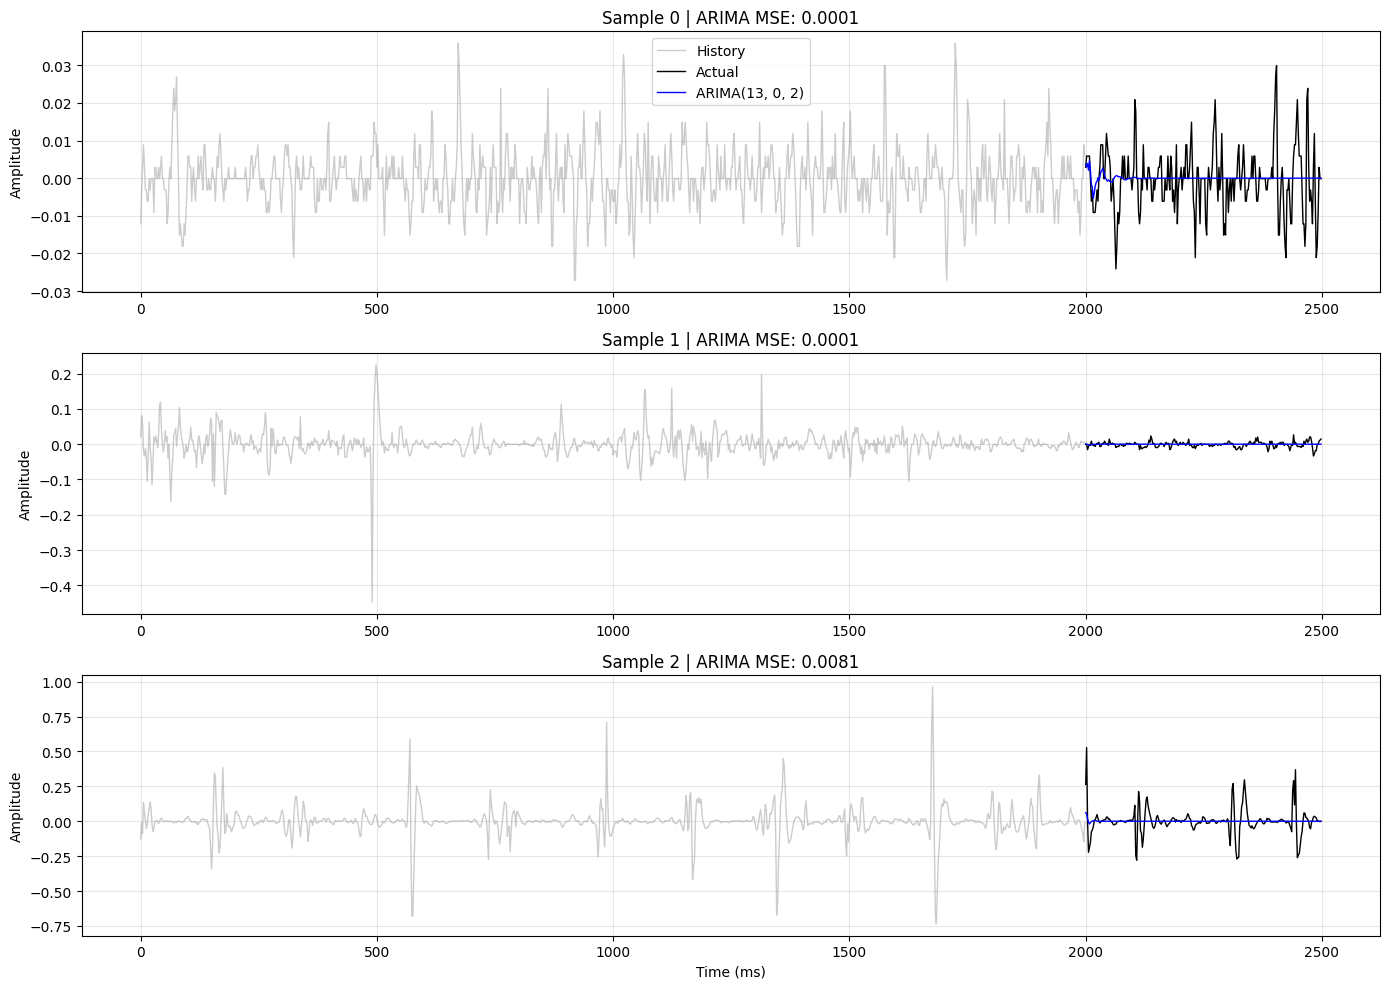

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
# Plot the first 3 successful ARIMA predictions
plot_count = min(3, len(arima_predictions))

time_hist = np.arange(0, T_OBS) * DT
time_pred = np.arange(T_OBS, T_OBS + T_PRED) * DT

for i in range(plot_count):
    ax = axes[i]
    
    # Identify the global index to fetch history
    global_idx = arima_indices[i]
    
    # Plot History
    ax.plot(time_hist, X_test_history[global_idx], 'gray', linewidth=1, alpha=0.4, label='History')
    
    # Plot Target
    ax.plot(time_pred, arima_targets[i], 'k-', linewidth=1, label='Actual')
    
    # Plot ARIMA Forecast
    ax.plot(time_pred, arima_predictions[i], 'b-', linewidth=1, label=f'ARIMA{ARIMA_ORDER}')
    
    # Optional: If we had AR predictions for these specific indices, we could overlay them.
    # But since indices are random, we focus on the ARIMA performance here.
    
    ax.set_title(f"Sample {global_idx} | ARIMA MSE: {arima_mses[i]:.4f}")
    ax.set_ylabel("Amplitude")
    if i == 0: ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

Clearly, the results are not that much better than AR alone, suggesting that the added complexity may not be justified for this specific prediction task.

## 5. Time-Varying Autoregressive Models (TVAR)

Standard AR models assume the tissue properties (coefficients $\boldsymbol{\phi}$) are constant over the observation window. However, during arrhythmias, the heart rate and conduction velocity often change rapidly (non-stationarity). A TVAR model allows the coefficients to evolve over time:

$$
X_t = c(t) + \sum_{i=1}^{p} \phi_i(t) X_{t-i} + \varepsilon_t.
$$

To estimate the trajectory of $\phi_i(t)$​, we use Recursive Least Squares (RLS) via the Kalman Filter. This gives more weight to the most recent data points, allowing the model to capture the "instantaneous" physics of the tissue right before the prediction window starts.

### 5.1. RLS Implementation

We utilize `statsmodels.tsa.recursive.RecursiveLS`. Unlike the standard `AutoReg`, we must manually construct the matrix of regressors (lagged values) for the RLS solver.

In [ ]:
TVAR_LAG = min(AR_LAG, 50)
N_TVAR_SAMPLES = 50
tvar_indices = np.arange(N_TVAR_SAMPLES)
#tvar_indices = np.random.choice(len(X_test_history), N_TVAR_SAMPLES, replace=False)

tvar_predictions = []
tvar_targets = []
tvar_mses = []

print(f"Running TVAR (RLS) on {N_TVAR_SAMPLES} samples...")

for idx in tqdm.tqdm(tvar_indices):
    history = X_test_history[idx]
    target = X_test_target[idx]
    
    try:
        # 1. Construct Exogenous Matrix (Regressors)
        # For RLS, we need a matrix where row 't' contains [X_{t-1}, ..., X_{t-p}]
        # We construct this manually.
        
        # Create Lagged Matrix
        X_mat = []
        y_vec = []
        
        # We lose the first 'TVAR_LAG' points for initialization
        for t in range(TVAR_LAG, len(history)):
            lagged_vals = history[t - TVAR_LAG : t][::-1] # Reverse to get t-1, t-2...
            X_mat.append(lagged_vals)
            y_vec.append(history[t])
            
        X_mat = np.array(X_mat)
        y_vec = np.array(y_vec)
        
        # 2. Define and Fit RLS Model
        # This runs the Kalman Filter through the history to track parameter evolution
        model = RecursiveLS(y_vec, X_mat)
        res = model.fit()
        
        # 3. Forecast
        # RLS gives us the parameters at the *last* step of history: res.params[-1]
        # We use these "most recent" coefficients to project into the future.
        # (Assumption: Tissue properties remain stable for the next 0.5s)
        
        last_coeffs = res.recursive_coefficients.filtered[:, -1]
        
        # Iterative Prediction Loop
        current_history = list(history) # Start with full history
        pred_steps = []
        
        for _ in range(T_PRED):
            # Get last 'p' values
            # Note: Must match the order we built X_mat (t-1, t-2...)
            lags = np.array(current_history[-TVAR_LAG:][::-1])
            
            # Dot product
            next_val = np.dot(last_coeffs, lags)
            
            pred_steps.append(next_val)
            current_history.append(next_val)
            
        tvar_predictions.append(pred_steps)
        tvar_targets.append(target)
        tvar_mses.append(mean_squared_error(target, pred_steps))
        
    except Exception as e:
        print(f"TVAR Error sample {idx}: {e}")

tvar_predictions = np.array(tvar_predictions)
tvar_targets = np.array(tvar_targets)

print(f"\nCompleted. Average TVAR MSE: {np.mean(tvar_mses):.6f}")

# Metrics
tvar_global_mse, tvar_spike_mse = calculate_metrics(tvar_predictions, tvar_targets, "TVAR (RLS)")

Running TVAR (RLS) on 50 samples...


100%|██████████| 50/50 [00:01<00:00, 41.72it/s]



Completed. Average TVAR MSE: 0.006250
(50,)


50it [00:00, 12122.27it/s]

--- TVAR (RLS) Results ---
Global MSE:    0.006250
Spike MSE:     0.101578
Spike MAE:     0.178729


### 5.2. Coefficient Evolution Analysis

One of the main advantages of TVAR is interpretability. We can visualize how the model changed its mind about the "physics" of the signal over the 2-second history.

If the coefficients are flat lines, the signal was stationary. If they wiggle or jump, the tissue properties were changing.

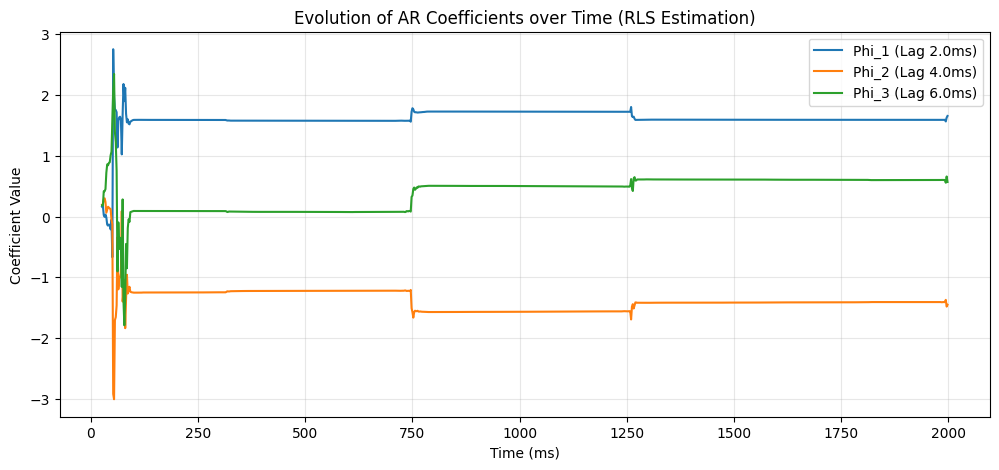

In [ ]:
# Visualize the evolution of the first 3 coefficients for the last processed sample
fig, ax = plt.subplots(figsize=(12, 5))

# res is from the last loop iteration
coefficients = res.recursive_coefficients.filtered.T  # Shape: (Time, Coefficients)
time_axis = np.arange(TVAR_LAG, len(history)) * DT

# Plot only first 3 coefficients for clarity
ax.plot(time_axis, coefficients[:, 0], label=f"Phi_1 (Lag {DT}ms)")
ax.plot(time_axis, coefficients[:, 1], label=f"Phi_2 (Lag {DT*2}ms)")
ax.plot(time_axis, coefficients[:, 2], label=f"Phi_3 (Lag {DT*3}ms)")

ax.set_title("Evolution of AR Coefficients over Time (RLS Estimation)")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Coefficient Value")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

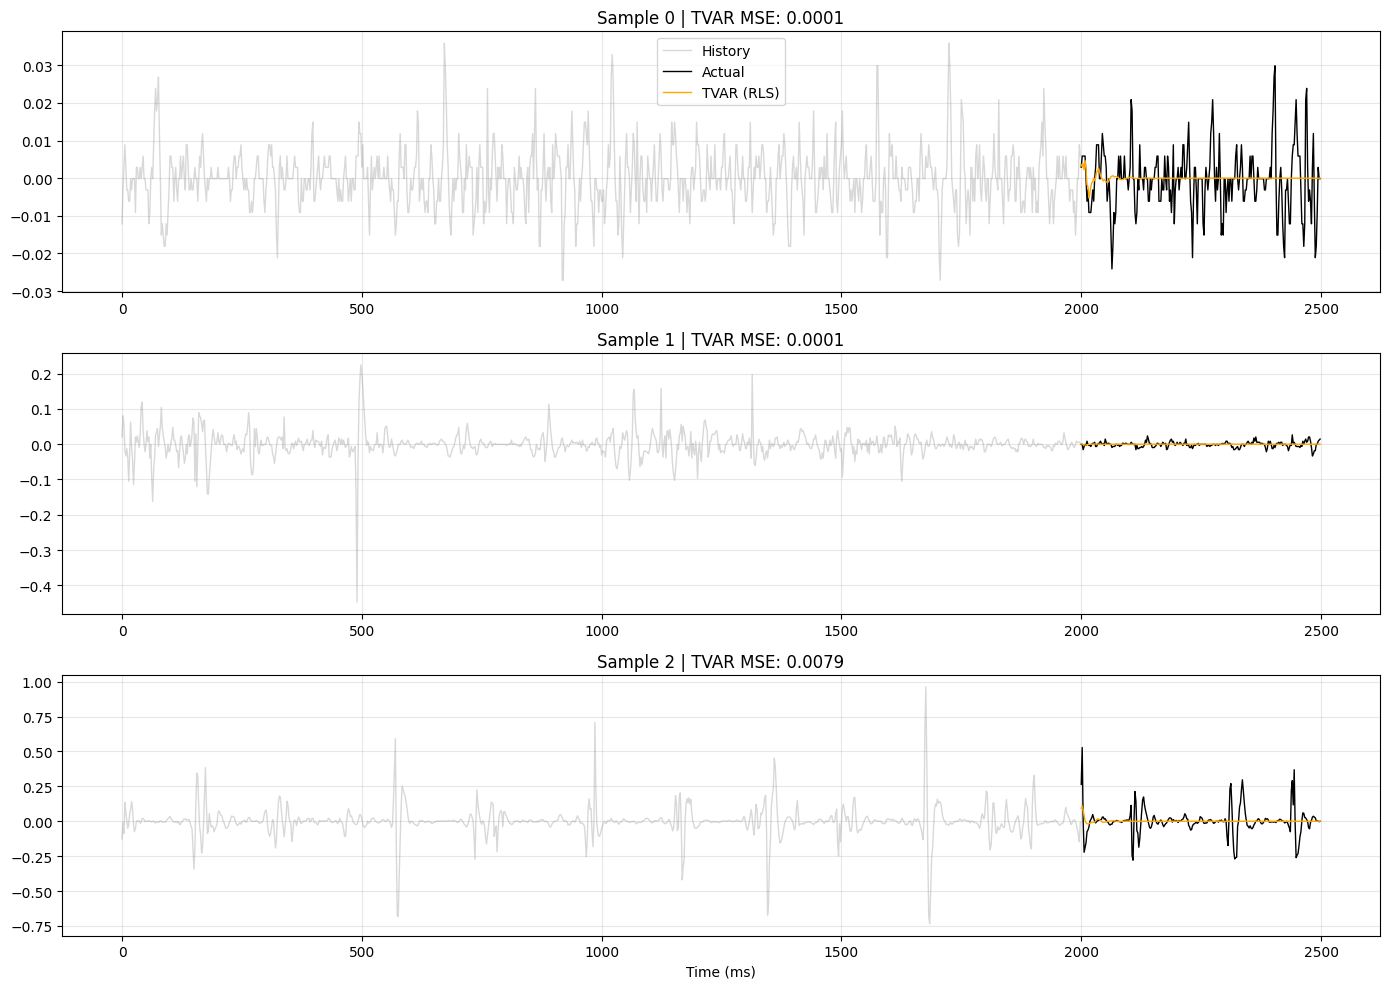

In [ ]:
fig, axes = plt.subplots(min(3, len(tvar_predictions)), 1, figsize=(14, 10))

for i in range(len(axes)):
    ax = axes[i]
    
    # Global index
    global_idx = tvar_indices[i]
    
    # Plot History
    ax.plot(np.arange(0, T_OBS)*DT, X_test_history[global_idx], "gray", linewidth=1, alpha=0.3, label="History")
    
    # Plot Target
    time_pred = np.arange(T_OBS, T_OBS + T_PRED) * DT
    ax.plot(time_pred, tvar_targets[i], "k-", linewidth=1, label="Actual")
    
    # Plot TVAR
    ax.plot(time_pred, tvar_predictions[i], "orange", linestyle='-', linewidth=1, label="TVAR (RLS)")

    ax.set_title(f"Sample {global_idx} | TVAR MSE: {tvar_mses[i]:.4f}")
    ax.grid(True, alpha=0.3)
    if i==0: ax.legend()

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

## 6. Final Model Comparison

We now aggregate the results from all autoregressive architectures tested.

In [ ]:
results_data = []

# 1. AR Results
if "ar_global_mse" in locals():
    results_data.append({
        "Model": f"AR({AR_LAG})",
        "Type": "Linear / Static",
        "Global MSE": ar_global_mse,
        "Spike MSE": ar_spike_mse
    })

# 2. ARIMA Results
if "arima_global_mse" in locals():
    results_data.append({
        "Model": f"ARIMA{ARIMA_ORDER}",
        "Type": "Iterative / MA",
        "Global MSE": arima_global_mse,
        "Spike MSE": arima_spike_mse
    })

# 3. TVAR Results
if "tvar_global_mse" in locals():
    results_data.append({
        "Model": f"TVAR (Lag {TVAR_LAG})",
        "Type": "Time-Varying (RLS)",
        "Global MSE": tvar_global_mse,
        "Spike MSE": tvar_spike_mse
    })

# Create DataFrame
results_df = pd.DataFrame(results_data)
results_df = results_df.set_index("Model")

print("="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
print(results_df.sort_values(by="Spike MSE"))

FINAL PERFORMANCE SUMMARY
                               Type  Global MSE  Spike MSE
Model                                                     
AR(13)              Linear / Static     0.00625   0.101578
TVAR (Lag 13)    Time-Varying (RLS)     0.00625   0.101578
ARIMA(13, 0, 2)      Iterative / MA     0.00621   0.101595


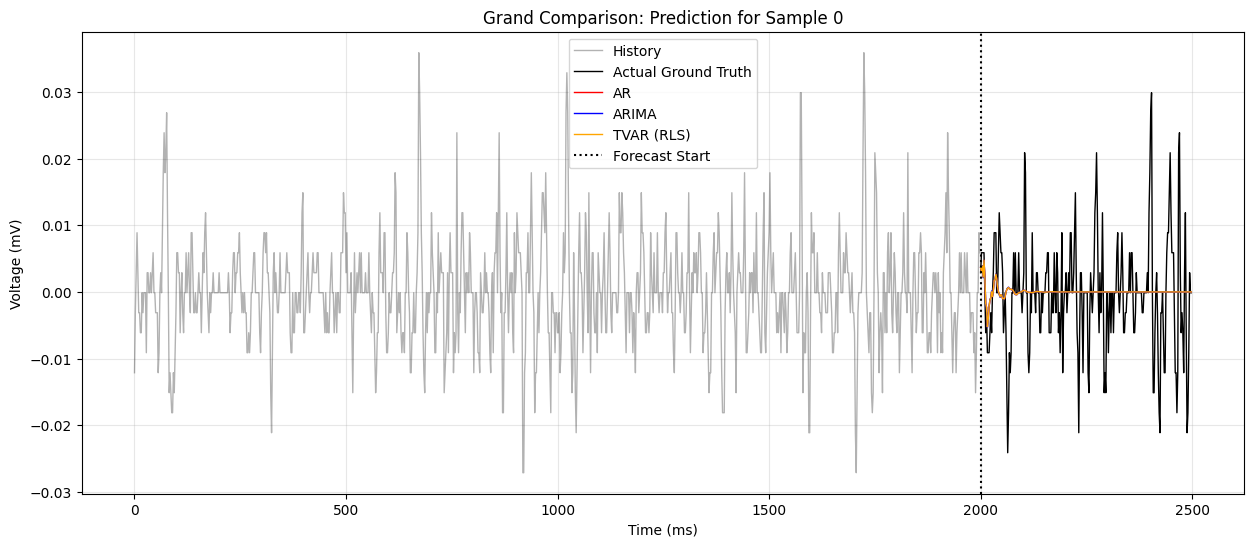

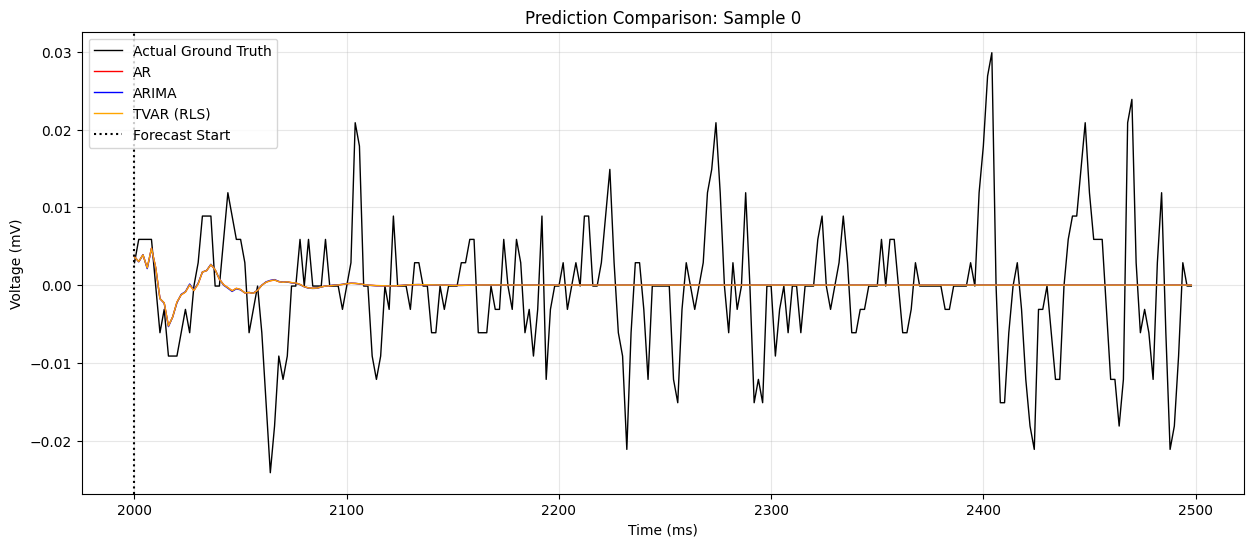

In [ ]:
sample_idx = 0 # np.random.randint(0, len(X_test_history))
history = X_test_history[sample_idx]
target = X_test_target[sample_idx]

plt.figure(figsize=(15, 6))

# Plot History & Target
plt.plot(time_hist, history, 'k', linewidth=1, alpha=0.3, label="History")
plt.plot(time_pred, target, 'k', linewidth=1, label="Actual Ground Truth")

plt.plot(time_pred, ar_predictions[sample_idx], "r-", linewidth=1, label="AR")
plt.plot(time_pred, arima_predictions[sample_idx], "b-", linewidth=1, label="ARIMA")
plt.plot(time_pred, tvar_predictions[sample_idx], "orange", linestyle='-', linewidth=1, label="TVAR (RLS)")

plt.title(f"Grand Comparison: Prediction for Sample {sample_idx}")
plt.axvline(x=T_OBS*DT, color='k', linestyle=':', label="Forecast Start")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.grid(True, alpha=0.3)
plt.show()

# Plot only prediction region
plt.figure(figsize=(15, 6))
plt.plot(time_pred, target, 'k', linewidth=1, label='Actual Ground Truth')

plt.plot(time_pred, ar_predictions[sample_idx], "r-", linewidth=1, label="AR")
plt.plot(time_pred, arima_predictions[sample_idx], "b-", linewidth=1, label="ARIMA")
plt.plot(time_pred, tvar_predictions[sample_idx], "orange", linestyle='-', linewidth=1, label="TVAR (RLS)")

plt.title(f"Prediction Comparison: Sample {sample_idx}")
plt.axvline(x=T_OBS*DT, color='k', linestyle=':', label="Forecast Start")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.grid(True, alpha=0.3)
plt.show()  

## 7. Conclusions

Overall, the AR family of models achieve good metrics for EGM signal prediction, but when we actually look at the spike predictions, the performance is terrible, only catching very dampened versions of the spikes up to around 100 ms into the prediction horizon. Beyond that, the models revert to predicting flat lines. So, they are not useful for this task.